# Fully connected feedforward network implementing a loss mask

In [ ]:
import torchmetrics.classification
from torch import cuda

assert cuda.is_available()
assert cuda.device_count() > 0

In [ ]:
print(cuda.get_device_name(cuda.current_device()))


NVIDIA GeForce RTX 3060 Ti


In [ ]:
import torch
import torch.nn as nn

In [ ]:
DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)

### Load the Dataset

In [ ]:
from src.maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
)

driams.loading_type = "memory"

driams

/home/jan/Uni/master/src/maldi2resistance/data/driams.py:54: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__meta[key] = pd.read_csv(root_dir / f"{site}/id/{year}/{year}_clean.csv")
100%|██████████| 55780/55780 [00:12<00:00, 4502.91it/s]


Antibiotic:,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,Clarithromycin,Clindamycin,Colistin,Cotrimoxazole,Ertapenem,Erythromycin,Fosfomycin,Fosfomycin-Trometamol,Fusidic acid,Gentamicin,Imipenem,Levofloxacin,Meropenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
Number resistant:,1068,13366,8578,21966,628,618,4223,7383,2338,3470,8659,5855,9338,310,4381,2874,7405,427,5468,2303,1326,3620,3481,7560,4217,5194,570,1271,1205,5537,12431,7616,486,580,244,3534,1707,227
Number susceptible:,20941,24992,4194,4905,456,457,5813,31567,4382,24566,28464,8368,36822,1262,9841,15784,24590,21740,9044,10184,4803,8498,22662,31717,17989,27228,4656,3603,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
Number data points:,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,37123,14223,46160,1572,14222,18658,31995,22167,14512,12487,6129,12118,26143,39277,22206,32422,5226,4874,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


In [ ]:
from bio_attention.attention import TransformerEncoder
from bio_attention.embed import ContinuousEmbedding

from x_transformers import TransformerWrapper, Decoder, Encoder

#model = TransformerWrapper(
#    num_tokens = 20000,
#    max_seq_len = 18000,
#    emb_dropout = 0.1,         # dropout after embedding
#    attn_layers = Decoder(
#        dim = 232,
#        depth = 4,
#        heads = 4,
#        layer_dropout = 0.1,   # stochastic depth - dropout entire layer
#        attn_dropout = 0.1,    # dropout post-attention
#        ff_dropout = 0.1       # feedforward dropout
#    )
#)

In [ ]:
import numpy as np
from maldi_nn.spectrum import SpectrumObject
from maldi_nn.nn import Transformer
import maldi_nn
from multimodal_amr.models.modules import ResMLP


class Model(nn.Module):
    def __init__(self, out_dim):
        super(Model, self).__init__()

        self.one = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=17)
        self.one_batch = nn.BatchNorm1d(64)
        
        self.two = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=9)
        self.two_batch = nn.BatchNorm1d(128)
        
        self.three = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5)
        self.three_batch = nn.BatchNorm1d(256)
        
        self.four = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=5)
        self.four_batch = nn.BatchNorm1d(256)
        
        self.flatten = nn.Flatten()
        
        self.layer_1 = nn.Linear(286720, 256)
        self.layer_2 = nn.Linear(256, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_4 = nn.Linear(64, out_dim)
        
        self.maxPooling = nn.MaxPool1d(2)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        
        _h = self.maxPooling(self.LeakyReLU(self.one(x)))
        _h = self.one_batch(_h)
        
        _h = self.maxPooling(self.LeakyReLU(self.two(_h)))
        _h = self.two_batch(_h)
        
        _h = self.maxPooling(self.LeakyReLU(self.three(_h)))
        _h = self.three_batch(_h)
        
        _h = self.maxPooling(self.LeakyReLU(self.four(_h)))
        _h = self.four_batch(_h)
        
        _h = self.flatten(_h)
        
        _h = self.LeakyReLU(self.layer_1(_h))
        _h = self.LeakyReLU(self.layer_2(_h))
        _h = self.LeakyReLU(self.layer_3(_h))
        _h = torch.sigmoid(self.layer_4(_h))

        return _h


In [ ]:
from torchsummary import summary

model = Model(out_dim= len(driams.selected_antibiotics))

model(torch.randn( (5, 1, 18000) )).shape

torch.Size([5, 38])

In [ ]:
len(driams.label_stats.columns)

38

In [ ]:
model = Model(out_dim=len(driams.selected_antibiotics))
model.to(DEVICE)

Model(
  (one): Conv1d(1, 64, kernel_size=(17,), stride=(1,))
  (one_batch): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (two): Conv1d(64, 128, kernel_size=(9,), stride=(1,))
  (two_batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (three): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (three_batch): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (four): Conv1d(256, 256, kernel_size=(5,), stride=(1,))
  (four_batch): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=286720, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=38, bias=True)
  (maxPooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
gen = torch.Generator()

batch_size = 32

train_size = int(0.8 * len(driams))
test_size = len(driams) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(driams, [train_size, test_size], generator=gen.manual_seed(SEED))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
from maldi2resistance.loss.maskedLoss import MaskedBCE
from tqdm.auto import tqdm
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

print("Start training ...")
model.train()

optimizer = Adam(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_per_batch = []

criterion = nn.BCELoss()

class_weights_negative = torch.tensor((1 - (driams.label_stats.loc["negative"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)
class_weights_positive = torch.tensor((1 - (driams.label_stats.loc["positive"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)

criterion = MaskedBCE(class_weights_positive= class_weights_negative, class_weights_negative= class_weights_negative)

for epoch in tqdm(range(30)):
    overall_loss = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):

        x = x.to(DEVICE)
        x = x[:,None,:]
        y = y.to(DEVICE)
        
        optimizer.zero_grad()

        # output, mean, log_var = model(x)
        output = model(x)

        #loss = loss_function(y, output, mean, log_var)
        loss = criterion(output, y)
        current_loss_value = loss.item()
        loss_per_batch.append(current_loss_value)
        
        overall_loss += current_loss_value
        
        loss.backward()
        optimizer.step()

    scheduler.step()
    with tqdm.external_write_mode():
        print(f"\tAverage Loss: {overall_loss / (batch_idx*batch_size):.6f} \tLearning rate: {scheduler.get_last_lr()[0]:.6f}")


print("Finish")

Start training ...


  0%|          | 0/30 [00:00<?, ?it/s]

	Average Loss: 0.000994 	Learning rate: 0.001000
	Average Loss: 0.000815 	Learning rate: 0.001000
	Average Loss: 0.000733 	Learning rate: 0.001000
	Average Loss: 0.000645 	Learning rate: 0.001000
	Average Loss: 0.000555 	Learning rate: 0.001000
	Average Loss: 0.000455 	Learning rate: 0.001000
	Average Loss: 0.000375 	Learning rate: 0.001000
	Average Loss: 0.000299 	Learning rate: 0.001000
	Average Loss: 0.000241 	Learning rate: 0.001000
	Average Loss: 0.000198 	Learning rate: 0.000500
	Average Loss: 0.000107 	Learning rate: 0.000500
	Average Loss: 0.000056 	Learning rate: 0.000500
	Average Loss: 0.000034 	Learning rate: 0.000500
	Average Loss: 0.000023 	Learning rate: 0.000500
	Average Loss: 0.000017 	Learning rate: 0.000500
	Average Loss: 0.000013 	Learning rate: 0.000500
	Average Loss: 0.000010 	Learning rate: 0.000500
	Average Loss: 0.000008 	Learning rate: 0.000500
	Average Loss: 0.000006 	Learning rate: 0.000500
	Average Loss: 0.000005 	Learning rate: 0.000250
	Average Loss: 0.000

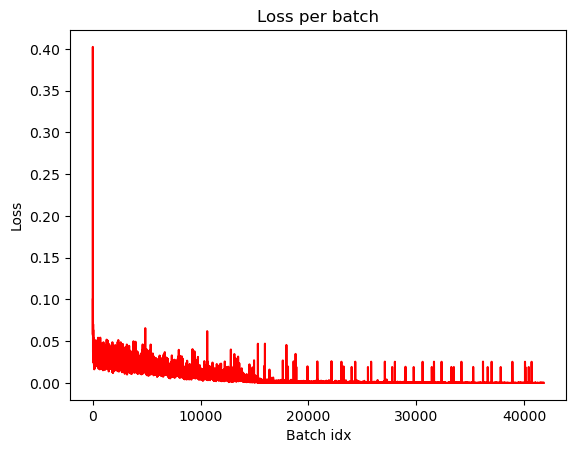

In [ ]:
import matplotlib.pyplot as plt 

plt.title("Loss per batch") 
plt.xlabel("Batch idx") 
plt.ylabel("Loss") 
plt.plot(list(range(0,len(loss_per_batch))),loss_per_batch , color ="red") 
plt.savefig("/home/jan/Uni/master/data/loss/MaskedWeightLoss.png" , transparent=True, format= "png", bbox_inches = "tight")
plt.show()

In [ ]:
model.eval()

Model(
  (one): Conv1d(1, 64, kernel_size=(17,), stride=(1,))
  (one_batch): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (two): Conv1d(64, 128, kernel_size=(9,), stride=(1,))
  (two_batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (three): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (three_batch): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (four): Conv1d(256, 256, kernel_size=(5,), stride=(1,))
  (four_batch): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=286720, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=38, bias=True)
  (maxPooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'selected_antibiotics': driams.selected_antibiotics
            }, './model.pt')